### Analyze the full S&P dataset that we built in an Atom IDE

In [1]:
#Load the required libraries

import pandas as pd
import numpy as np
import pickle

In [2]:
#Load the dataset that contains our historical pricing
file =  "filings_returns_nlp.p"
data = pickle.load( open( file, "rb" ) )

print(data.head())


  Ticker     Company  GICS Sector         GICS Sub Industry Report_Period  \
0    MMM  3M Company  Industrials  Industrial Conglomerates          2019   
1    MMM  3M Company  Industrials  Industrial Conglomerates          2019   
2    MMM  3M Company  Industrials  Industrial Conglomerates          2019   
3    MMM  3M Company  Industrials  Industrial Conglomerates          2019   
4    MMM  3M Company  Industrials  Industrial Conglomerates          2019   

  Filing_Date   Cos_Sim  Word_chg       Date Adj_Close  
0  2020-02-06  0.932309 -0.101716 2020-02-06   158.401  
1  2020-02-06  0.932309 -0.101716 2020-02-07   155.668  
2  2020-02-06  0.932309 -0.101716 2020-02-10   155.736  
3  2020-02-06  0.932309 -0.101716 2020-02-11   157.973  
4  2020-02-06  0.932309 -0.101716 2020-02-12   159.286  


**Cleanup the dataset and transform columns for analysis**

In [3]:
#recast the date columns to filter on it later
data['Year'] = data['Date'].dt.to_period('Y')
data = data.astype({"Year":'str'})

#Need to remove the nan values from the Word_chg column.
data = data.dropna()
data = data.reset_index(drop=True) #made the decision to drop the na values , handles the ?
#turn word_chg vector into a signal (-1 reduction in neg, 1 increase in neg)
data['Word_chg'] = np.sign(data['Word_chg'] )  

#calc the daily return data
data["Return"] = data.groupby([data.Year,data.Ticker]).Adj_Close.pct_change(1)

#convert date into datetime for later resampling purposes 
data['Date'] = data.loc[:,'Date'].astype('datetime64[ns]')
data['Return'] = pd.to_numeric(data['Return'])
data = data.dropna()

#check we successfully clean up the dataset and removed the nulls
data.isna().sum()

Ticker               0
Company              0
GICS Sector          0
GICS Sub Industry    0
Report_Period        0
Filing_Date          0
Cos_Sim              0
Word_chg             0
Date                 0
Adj_Close            0
Year                 0
Return               0
dtype: int64

In [4]:
#group the dataset by the datapoints per year for each stock
yearly_returns = data.groupby( 
    ['Year','Ticker']).apply(lambda x: x.sort_values(["Date"], ascending = False)).reset_index(drop=True)
yearly_returns.head()

,Ticker,Company,GICS Sector,GICS Sub Industry,Report_Period,Filing_Date,Cos_Sim,Word_chg,Date,Adj_Close,Year,Return
0,A,Agilent Technologies Inc,Health Care,Health Care Equipment,2015,2015-12-21,0.997459,1.0,2015-12-31,40.0089,2015,-0.005826
1,A,Agilent Technologies Inc,Health Care,Health Care Equipment,2015,2015-12-21,0.997459,1.0,2015-12-30,40.2433,2015,-0.004485
2,A,Agilent Technologies Inc,Health Care,Health Care Equipment,2015,2015-12-21,0.997459,1.0,2015-12-29,40.4246,2015,0.013882
3,A,Agilent Technologies Inc,Health Care,Health Care Equipment,2015,2015-12-21,0.997459,1.0,2015-12-28,39.8712,2015,-0.008543
4,A,Agilent Technologies Inc,Health Care,Health Care Equipment,2015,2015-12-21,0.997459,1.0,2015-12-24,40.2147,2015,0.008858


### Calculate the returns and sharpe ratio for the overall analysis

In [5]:
def get_ret_sharpe(returns, term):
    
    deviations = returns - returns.mean()
    squared_deviations = deviations **2
    num_of_obs = returns.shape[0]
    variance = squared_deviations.sum()/ (num_of_obs -1)
    volatility = np.sqrt(variance)
    annualized_vol = returns.std()*np.sqrt(252)  #daily trading returns
    n_days = num_of_obs
    return_per_day = (returns+1).prod()**(1/n_days) - 1
    annualized_return = ((return_per_day+1)**252 -1)*100
    riskfreerate = .025
    excess_return = annualized_return - riskfreerate
    sharpe = excess_return/annualized_vol
    return annualized_return, sharpe

In [22]:
#Portfolio: short the changers, go long non-changers

returns_sharpe_dict =  {'Months':[],'Investment':[],'Returns':[],'Sharpe':[]}

# print(df1.shape)
for term in range(30,210,30):
    
    #view portfolio returns by trading days within window per year for the basket
    daily = yearly_returns.groupby(['Year','Ticker']).head(term)
    
    year  = ['2015','2016','2017','2018','2019','2020']
    tkr_by_year = daily[daily.Year.isin(year)]
    
    df1 = tkr_by_year.loc[(tkr_by_year['Cos_Sim'] < tkr_by_year['Cos_Sim'].quantile(0.20)) &
                    (tkr_by_year['Word_chg'] == 1)] #bottom quantile of CSim due to an increase in neg word frequency
    
    df2 = tkr_by_year.loc[(tkr_by_year['Cos_Sim'] > tkr_by_year['Cos_Sim'].quantile(0.80)) &
                    (tkr_by_year['Word_chg'] == -1)] #top quantile of CSim due to a small change in neg word frequency
    
    market = tkr_by_year['Return']
    market_alpha = get_ret_sharpe(market, term) #review the dispersion in the sectors at the 60day time window
    market_alpha_ret = round(market_alpha[0],3)
    market_alpha_shp = round(market_alpha[1],3)
    returns_sharpe_dict['Months'].append(term/30)
    returns_sharpe_dict['Investment'].append("Market")
    returns_sharpe_dict['Returns'].append(market_alpha_ret)
    returns_sharpe_dict['Sharpe'].append(market_alpha_shp)
    
    changers = df1['Return']
    change_alpha = get_ret_sharpe(changers, term)
    change_alpha_ret = round(change_alpha[0],3)
    change_alpha_shp = round(change_alpha[1],3)
    returns_sharpe_dict['Months'].append(term/30)
    returns_sharpe_dict['Investment'].append("Changers")
    returns_sharpe_dict['Returns'].append(change_alpha_ret)
    returns_sharpe_dict['Sharpe'].append(change_alpha_shp)
    
    non_changers = df2['Return'] #all stocks in dataset, no filter
    nonchange_data = get_ret_sharpe(non_changers, term)
    nonchange_ret = round(nonchange_data[0],3)
    nonchange_shp = round(nonchange_data[1],3)
    returns_sharpe_dict['Months'].append(term/30)
    returns_sharpe_dict['Investment'].append("Non-changers")
    returns_sharpe_dict['Returns'].append(nonchange_ret)
    returns_sharpe_dict['Sharpe'].append(nonchange_shp)
    
return_comp = pd.DataFrame(returns_sharpe_dict)


**Abnormal returns are not immediately reflected after corporate filings indicating an opportunity to scale into hedged or arbitraged strategies.** 

One important note on the backdrop of this period of study from 2015 through 2020, the market experienced only 1 down year (-4% in 2018, the other years all returned double digits.

### Findings from 5 year returns - Table below over the 6month post filing trading window:
1. After the 1st month, there's virtually no difference bewtween portfolios 
- *If there were important disclosures made in the risk section, there was little reaction thus far*

2. In the 2nd month following the financial filing, we now see word changes in firms's public filings leading to underperformance. 
- *The market likely catches up to the risk disclosure updates.*
3. In the 3rd month, that environment persisted.  
- *Negative-sentiment word changing firms continued to underperform.*
4. By the 4th month, that variance has largely been removed.
5. Interestingly, in the 6mos that underpormance from the negative-sentiment changing firms appeared again.

In [23]:
return_comp.style.format({ 
                          "Returns": "{:20,.0f}%",
                          "Sharpe": "{:20,.0f}", 
                          "Months": "{:20,.0f}mos"})\
                    .background_gradient(cmap='viridis')\
                    .set_caption('Market Portfolio and 10-K Negative-Sentiment Risk Adjusted Returns Over 6mo Trading Window')

,Months,Investment,Returns,Sharpe
0,1mos,Market,-1%,-4
1,1mos,Changers,-1%,-4
2,1mos,Non-changers,2%,8
3,2mos,Market,9%,33
4,2mos,Changers,4%,14
5,2mos,Non-changers,16%,54
6,3mos,Market,10%,31
7,3mos,Changers,4%,12
8,3mos,Non-changers,10%,32
9,4mos,Market,15%,49


**Plot the return datapoints by months post 10K filing report**

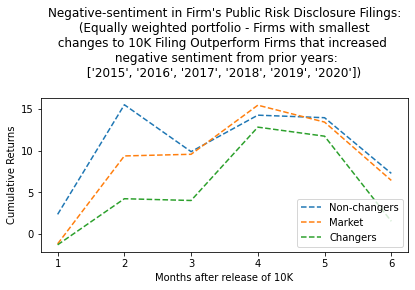

In [24]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for type in ['Non-changers','Market','Changers']:
    ax.plot(return_comp[return_comp.Investment==type].Months,
            return_comp[return_comp.Investment==type].Returns,
            label=type, linestyle=('--'))

ax.set_title("Negative-sentiment in Firm's Public Risk Disclosure Filings:\n "
             "(Equally weighted portfolio - Firms with smallest \n "
             "changes to 10K Filing Outperform Firms that increased  \n negative "
             "sentiment from prior years:\n {}) \n".format(year))
ax.set_xlabel("Months after release of 10K")
ax.set_ylabel("Cumulative Returns")
ax.legend(loc='lower right')

plt.tight_layout()
plt.subplots_adjust(top=.68)     # Add space at top

plt.savefig("sector_return_curve.png", dpi = 75)

plt.show()

Both portfolios regardless of risk disclosure sentiment were relatively unchanged in the 1st month following the publication of the firm's 10k.  This likely indicates 10-K risk disclosure information was not yet impounded into stock prices, however as noticed in the plot above, the greatest divergence began to appear in months 2 and 3.  The gap narrowed in the subsequent periods through month 6 however the divergence remained over the analysis period.  
**Possible implications for creating the following portfolios:**
1. Long/Short event driven
2. Dispersion portfolios
3. Long/Short ATM straddle portfolios

In [9]:
#The two month window reflected the greatest premium between this strategy of applying NLP negative term frequency analysis


sector_returns_dict =  {'Sector':[],'Investment':[],'Returns':[] }
term = 60
daily = yearly_returns.groupby(['Year','Ticker']).head(term)

for sector in daily['GICS Sector'].unique():
    
    sectors = daily[daily['GICS Sector'] == sector]
    
    df1 = sectors.loc[(sectors['Cos_Sim'] < sectors['Cos_Sim'].quantile(0.50)) &
                    (sectors['Word_chg'] == 1)] #bottom quantile of CSim due to an increase in neg word frequency
    
    df2 = sectors.loc[(sectors['Cos_Sim'] > sectors['Cos_Sim'].quantile(0.50)) &
                    (sectors['Word_chg'] == -1)] #top quantile of CSim due to a small change in neg word frequency
    
    changers = df1['Return']
    
    change_alpha = get_ret_sharpe(changers, term) #review the dispersion in the sectors at the 60day time window
    change_alpha_ret = round(change_alpha[0],3)
    change_alpha_shp = round(change_alpha[1],3)
    sector_returns_dict['Sector'].append(sector)
    sector_returns_dict['Investment'].append("Changers")
    sector_returns_dict['Returns'].append(change_alpha_ret)
#     sector_returns_dict['Sharpe'].append(change_alpha_shp)
    
    non_changers = df2['Return'] #all stocks in dataset, no filter

    nonchange_data = get_ret_sharpe(non_changers, term) #review the dispersion in the sectors at the 60day time window
    nonchange_ret = round(nonchange_data[0],3)
    nonchange_shp = round(nonchange_data[1],3)
    sector_returns_dict['Sector'].append(sector)
    sector_returns_dict['Investment'].append("Non-changers")
    sector_returns_dict['Returns'].append(nonchange_ret)
#     sector_returns_dict['Sharpe'].append(nonchange_shp)
    
return_mo_comp = pd.DataFrame(sector_returns_dict)


In [10]:
return_mo_comp.style.format({ 
                          "Returns": "{:20,.0f}%", 
                          "Investment": str.upper})\
                    .background_gradient(cmap='viridis')\
                    .set_caption('Sector Risk Adjusted Returns At Two-Month Trading Window')

,Sector,Investment,Returns
0,Health Care,CHANGERS,4%
1,Health Care,NON-CHANGERS,9%
2,Information Technology,CHANGERS,21%
3,Information Technology,NON-CHANGERS,11%
4,Materials,CHANGERS,23%
5,Materials,NON-CHANGERS,-2%
6,Utilities,CHANGERS,4%
7,Utilities,NON-CHANGERS,20%
8,Consumer Discretionary,CHANGERS,-1%
9,Consumer Discretionary,NON-CHANGERS,22%


In [11]:
#create a bar chart with the sector comparisons

data_piv = return_mo_comp.pivot_table(values='Returns', index=return_mo_comp.Sector, columns='Investment', aggfunc='first')

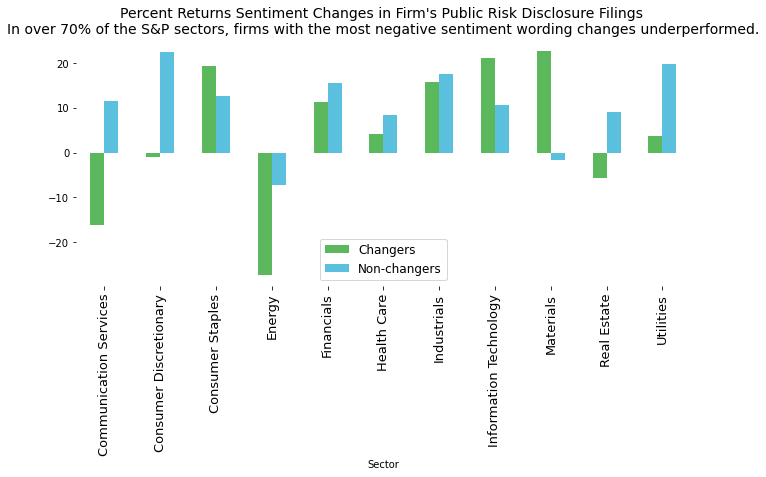

In [12]:
# data_piv.plot.bar()

colors_list = ['#5cb85c','#5bc0de']
data_piv.plot(kind='bar',figsize=(11,9),width = 0.5,color = colors_list,edgecolor=None)
plt.legend(labels=data_piv.columns,fontsize= 12, loc='lower center')
plt.title("Percent Returns Sentiment Changes in Firm's Public Risk Disclosure Filings \n"
          "In over 70% of the S&P sectors, firms with the most negative sentiment wording changes underperformed.",fontsize= 14)

plt.xticks(fontsize=13)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.subplots_adjust(bottom=0.5)

plt.savefig("sector_barchart.png", dpi = 75)

plt.show()

In [13]:
#recreate charts for each sector showing the return curves over the trading window horizon


sector_returns_dict =  {'Months':[],'Sector':[],'Investment':[],'Returns':[],'Sharpe':[] }

# print(df1.shape)
for term in range(30,210,30):
    
    #view portfolio returns by trading days within window per year for the basket
    daily = yearly_returns.groupby(['Year','Ticker']).head(term)
    
    for sector in daily['GICS Sector'].unique():
        
        sectors = daily[daily['GICS Sector'] == sector]
        df1 = sectors.loc[(sectors['Cos_Sim'] < sectors['Cos_Sim'].quantile(0.50)) &
                    (sectors['Word_chg'] == 1)] #bottom quantile of CSim due to an increase in neg word frequency
        df2 = sectors.loc[(sectors['Cos_Sim'] > sectors['Cos_Sim'].quantile(0.50)) &
                    (sectors['Word_chg'] == -1)] #top quantile of CSim due to a small change in neg word frequency
    
        market_sector = sectors['Return']
    
        market_alpha = get_ret_sharpe(market_sector, term) #review the dispersion in the sectors at the 60day time window
        market_alpha_ret = round(market_alpha[0],3)
        market_alpha_shp = round(market_alpha[1],3)
        sector_returns_dict['Months'].append(term/30)
        sector_returns_dict['Sector'].append(sector)
        sector_returns_dict['Investment'].append(sector)
        sector_returns_dict['Returns'].append(market_alpha_ret)
        sector_returns_dict['Sharpe'].append(market_alpha_shp)
        
        changers = df1['Return']
    
        change_alpha = get_ret_sharpe(changers, term) #review the dispersion in the sectors at the 60day time window
        change_alpha_ret = round(change_alpha[0],3)
        change_alpha_shp = round(change_alpha[1],3)
        sector_returns_dict['Months'].append(term/30)
        sector_returns_dict['Sector'].append(sector)
        sector_returns_dict['Investment'].append("Changers")
        sector_returns_dict['Returns'].append(change_alpha_ret)
        sector_returns_dict['Sharpe'].append(change_alpha_shp)
    
        non_changers = df2['Return'] #all stocks in dataset, no filter

        nonchange_data = get_ret_sharpe(non_changers, term) #review the dispersion in the sectors at the 60day time window
        nonchange_ret = round(nonchange_data[0],3)
        nonchange_shp = round(nonchange_data[1],3)
        sector_returns_dict['Months'].append(term/30)
        sector_returns_dict['Sector'].append(sector)
        sector_returns_dict['Investment'].append("Non-changers")
        sector_returns_dict['Returns'].append(nonchange_ret)
        sector_returns_dict['Sharpe'].append(nonchange_shp)
    
return_comp_windows = pd.DataFrame(sector_returns_dict)


In [14]:
returns2mos = return_comp_windows.query('Months == 2')

returns2mos.style.format({ 
                          "Returns": "{:20,.0f}%",
                          "Months": "{:20,.0f}mos",
                          "Investment": str.upper})\
                    .background_gradient(cmap='viridis')\
                    .set_caption('Sector Risk Adjusted Returns - First Few Sectors')

,Months,Sector,Investment,Returns,Sharpe
33,2mos,Health Care,HEALTH CARE,2%,7.566000
34,2mos,Health Care,CHANGERS,4%,15.774000
35,2mos,Health Care,NON-CHANGERS,9%,31.017000
36,2mos,Information Technology,INFORMATION TECHNOLOGY,19%,60.654000
37,2mos,Information Technology,CHANGERS,21%,66.264000
38,2mos,Information Technology,NON-CHANGERS,11%,34.374000
39,2mos,Materials,MATERIALS,14%,51.728000
40,2mos,Materials,CHANGERS,23%,77.824000
41,2mos,Materials,NON-CHANGERS,-2%,-5.860000
42,2mos,Utilities,UTILITIES,14%,68.722000


In [15]:
return_comp_windows['Sector'][1]

'Health Care'

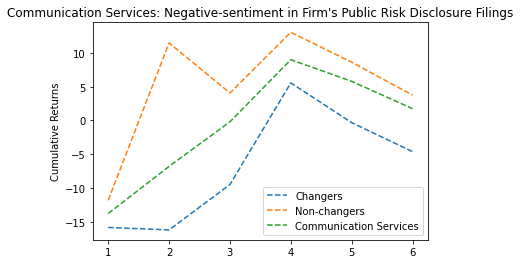

In [16]:
# return_comp_windows['Sector']

# for sector in return_comp_windows['Sector'].unique():
sector = 'Communication Services'
sectors = return_comp_windows[return_comp_windows['Sector'] == sector]  


import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for type in ['Changers','Non-changers', sector]:
    ax.plot(sectors[sectors.Investment==type].Months,
            sectors[sectors.Investment==type].Returns,
            label=type, linestyle=('--'))

ax.set_title("{}: Negative-sentiment in Firm's Public Risk Disclosure Filings".format(sector))
ax.set_ylabel("Cumulative Returns")
ax.legend(loc='best')

plt.show()

### Let's look through all the sectors to see which ones outperform and which do not work

In general, we'd expect the Market portfolio (complete universe of names) to exhibit 
 a similar return profile with that of the Non-changers segment (no significant 
 sentiment change YoY) or fall between the Non-changers and the Changers segment (increased 
 negative sentiment in public filings.)While 70% of the sectors underperformed those 
 sectors with firms' that had little change to its filings,Info Tech, Materials, and Consumer Staples displayed abnormal returns



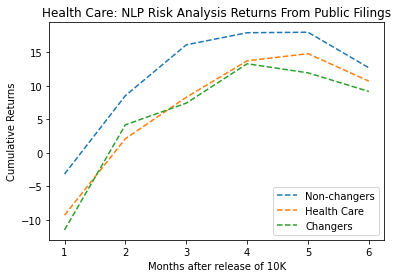

In general, we'd expect the Market portfolio (complete universe of names) to exhibit 
 a similar return profile with that of the Non-changers segment (no significant 
 sentiment change YoY) or fall between the Non-changers and the Changers segment (increased 
 negative sentiment in public filings.)While 70% of the sectors underperformed those 
 sectors with firms' that had little change to its filings,Info Tech, Materials, and Consumer Staples displayed abnormal returns



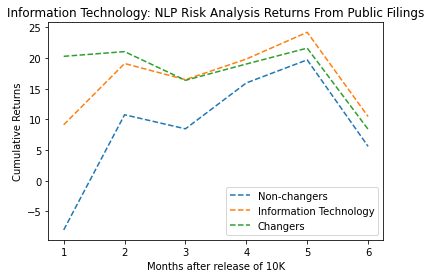

In general, we'd expect the Market portfolio (complete universe of names) to exhibit 
 a similar return profile with that of the Non-changers segment (no significant 
 sentiment change YoY) or fall between the Non-changers and the Changers segment (increased 
 negative sentiment in public filings.)While 70% of the sectors underperformed those 
 sectors with firms' that had little change to its filings,Info Tech, Materials, and Consumer Staples displayed abnormal returns



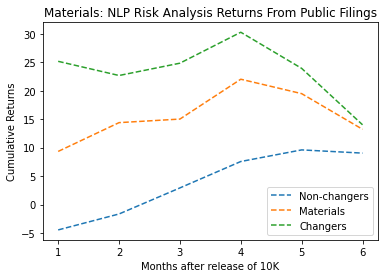

In general, we'd expect the Market portfolio (complete universe of names) to exhibit 
 a similar return profile with that of the Non-changers segment (no significant 
 sentiment change YoY) or fall between the Non-changers and the Changers segment (increased 
 negative sentiment in public filings.)While 70% of the sectors underperformed those 
 sectors with firms' that had little change to its filings,Info Tech, Materials, and Consumer Staples displayed abnormal returns



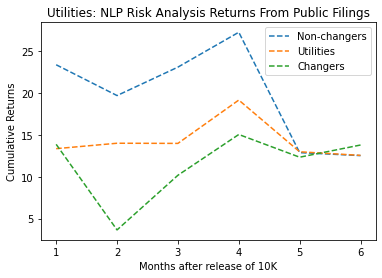

In general, we'd expect the Market portfolio (complete universe of names) to exhibit 
 a similar return profile with that of the Non-changers segment (no significant 
 sentiment change YoY) or fall between the Non-changers and the Changers segment (increased 
 negative sentiment in public filings.)While 70% of the sectors underperformed those 
 sectors with firms' that had little change to its filings,Info Tech, Materials, and Consumer Staples displayed abnormal returns



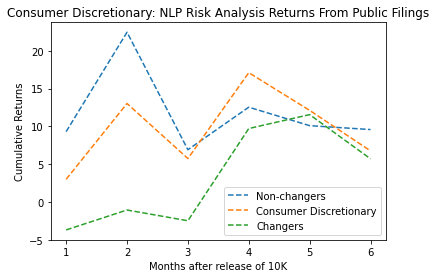

In general, we'd expect the Market portfolio (complete universe of names) to exhibit 
 a similar return profile with that of the Non-changers segment (no significant 
 sentiment change YoY) or fall between the Non-changers and the Changers segment (increased 
 negative sentiment in public filings.)While 70% of the sectors underperformed those 
 sectors with firms' that had little change to its filings,Info Tech, Materials, and Consumer Staples displayed abnormal returns



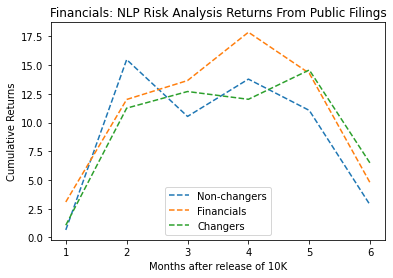

In general, we'd expect the Market portfolio (complete universe of names) to exhibit 
 a similar return profile with that of the Non-changers segment (no significant 
 sentiment change YoY) or fall between the Non-changers and the Changers segment (increased 
 negative sentiment in public filings.)While 70% of the sectors underperformed those 
 sectors with firms' that had little change to its filings,Info Tech, Materials, and Consumer Staples displayed abnormal returns



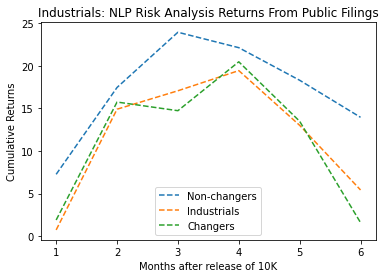

In general, we'd expect the Market portfolio (complete universe of names) to exhibit 
 a similar return profile with that of the Non-changers segment (no significant 
 sentiment change YoY) or fall between the Non-changers and the Changers segment (increased 
 negative sentiment in public filings.)While 70% of the sectors underperformed those 
 sectors with firms' that had little change to its filings,Info Tech, Materials, and Consumer Staples displayed abnormal returns



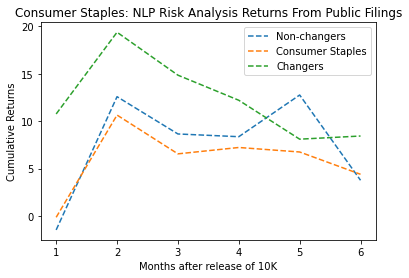

In general, we'd expect the Market portfolio (complete universe of names) to exhibit 
 a similar return profile with that of the Non-changers segment (no significant 
 sentiment change YoY) or fall between the Non-changers and the Changers segment (increased 
 negative sentiment in public filings.)While 70% of the sectors underperformed those 
 sectors with firms' that had little change to its filings,Info Tech, Materials, and Consumer Staples displayed abnormal returns



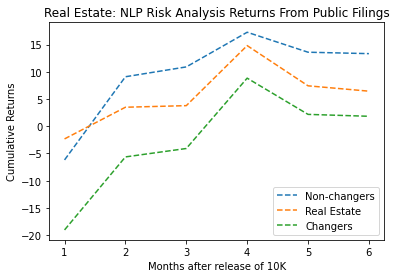

In general, we'd expect the Market portfolio (complete universe of names) to exhibit 
 a similar return profile with that of the Non-changers segment (no significant 
 sentiment change YoY) or fall between the Non-changers and the Changers segment (increased 
 negative sentiment in public filings.)While 70% of the sectors underperformed those 
 sectors with firms' that had little change to its filings,Info Tech, Materials, and Consumer Staples displayed abnormal returns



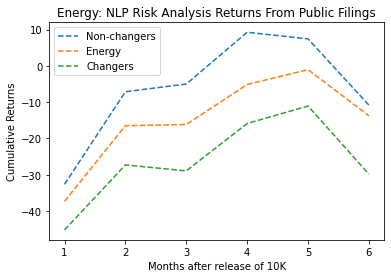

In general, we'd expect the Market portfolio (complete universe of names) to exhibit 
 a similar return profile with that of the Non-changers segment (no significant 
 sentiment change YoY) or fall between the Non-changers and the Changers segment (increased 
 negative sentiment in public filings.)While 70% of the sectors underperformed those 
 sectors with firms' that had little change to its filings,Info Tech, Materials, and Consumer Staples displayed abnormal returns



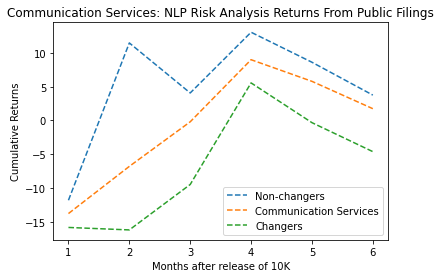

In [17]:
import matplotlib.pyplot as plt

for sector in return_comp_windows['Sector'].unique():

    sectors = return_comp_windows[return_comp_windows['Sector'] == sector]  

    fig,ax = plt.subplots()

    for type in ['Non-changers',sector,'Changers']:
        ax.plot(sectors[sectors.Investment==type].Months,
                sectors[sectors.Investment==type].Returns,
                label=type, linestyle=('--'))

    ax.set_title("{}: NLP Risk Analysis Returns From Public Filings".format(sector))
    ax.set_ylabel("Cumulative Returns")
    ax.set_xlabel("Months after release of 10K")
    ax.legend(loc='best')

    print("In general, we'd expect the Market portfolio (complete universe of names) to exhibit \n a similar return "
          "profile with that of the Non-changers segment (no significant \n sentiment change YoY) or fall" 
          " between the Non-changers and the Changers segment (increased \n negative sentiment in public filings.)"
         "While 70% of the sectors underperformed those \n sectors with firms' that had little change to its filings,"
         "Info Tech, Materials, and Consumer Staples displayed abnormal returns")
    print()
    
    plt.savefig("sector_return_curves.png", dpi = 75)
    
    plt.show()

### Why did the Materials sector perform so poorly?

In [18]:
sector = 'Materials'
sectors = return_comp_windows[return_comp_windows['Sector'] == sector] 

sectors.head(9)

,Months,Sector,Investment,Returns,Sharpe
6,1.0,Materials,Materials,9.338,31.577
7,1.0,Materials,Changers,25.157,80.735
8,1.0,Materials,Non-changers,-4.444,-14.668
39,2.0,Materials,Materials,14.393,51.728
40,2.0,Materials,Changers,22.668,77.824
41,2.0,Materials,Non-changers,-1.645,-5.860
72,3.0,Materials,Materials,15.019,51.961
73,3.0,Materials,Changers,24.832,79.107
74,3.0,Materials,Non-changers,2.932,10.050


In [19]:
#Is there a year in which this data is most distorted?

sector = ['Materials']
# year  = [2018]

sector_review = daily[daily['GICS Sector'].isin(sector)]

# print(sector_review['Ticker'].nunique())
sector_review.groupby( 
    ['Year']).agg(
     {  'Cos_Sim': "mean",
      'Word_chg': "min",
      'Return' :"sum",

     }
    )

,Cos_Sim,Word_chg,Return
Year,,,
2015,0.983291,-1.0,-0.060721
2016,0.921312,-1.0,3.347913
2017,0.959545,-1.0,3.023658
2018,0.928000,-1.0,-1.243142
2019,0.892698,-1.0,2.254263
2020,0.831064,-1.0,5.832675


In [20]:
# #2020 seems to be a significant outlier however in general most years weren't great either

rpt_year  = [2019]

year_in_review = sector_review[sector_review.Report_Period.isin(rpt_year)]

year_in_review.Filing_Date.unique()

<PeriodArray>
['2019-11-26', '2020-04-15', '2020-02-26', '2020-02-19', '2020-02-06',
 '2020-02-24', '2020-02-28', '2020-02-14', '2020-03-03', '2020-02-20',
 '2020-02-21', '2020-03-02']
Length: 12, dtype: period[D]

In [21]:
#November is a strange time to be filing a 10K report 

year_in_review.head()
#That nov fiing was indeed an outlier, cos sim was indicates that filing was quite different than prior years 
#howeverthe stock performed ok.


,Ticker,Company,GICS Sector,GICS Sub Industry,Report_Period,Filing_Date,Cos_Sim,Word_chg,Date,Adj_Close,Year,Return
219346,APD,Air Products & Chemicals Inc,Materials,Industrial Gases,2019,2019-11-26,0.295201,1.0,2019-12-31,231.096,2019,0.003502
219347,APD,Air Products & Chemicals Inc,Materials,Industrial Gases,2019,2019-11-26,0.295201,1.0,2019-12-30,230.289,2019,-0.000679
219348,APD,Air Products & Chemicals Inc,Materials,Industrial Gases,2019,2019-11-26,0.295201,1.0,2019-12-27,230.446,2019,-0.002499
219349,APD,Air Products & Chemicals Inc,Materials,Industrial Gases,2019,2019-11-26,0.295201,1.0,2019-12-26,231.023,2019,0.004382
219350,APD,Air Products & Chemicals Inc,Materials,Industrial Gases,2019,2019-11-26,0.295201,1.0,2019-12-24,230.015,2019,-0.000383


In [22]:
tkr_mask = year_in_review['Ticker'] != 'APD' 
# year  = [2018]

tkr_review = year_in_review[tkr_mask]

tkr_review.groupby( 
    ['Year','Ticker']).agg(
     {  'Cos_Sim': "mean",
      'Word_chg': "min",
      'Return' :"sum",
     }
    )

Cos_Sim  Word_chg    Return
Year Ticker                              
2020 ALB     0.017148      -1.0  0.253630
     AVY     0.994736      -1.0  0.201628
     BLL     0.986218       1.0  0.232457
     CE      0.866969       1.0  0.226629
     CF      0.991064       1.0 -0.050424
     ECL     0.978758      -1.0  0.226670
     EMN     1.000000       0.0  0.416155
     FCX     0.973755       1.0  0.567102
     FMC     0.955837      -1.0  0.282359
     IFF     1.000000       1.0  0.064343
     IP      0.942906       1.0  0.159860
     LYB     0.997766       1.0  0.223023
     MLM     0.000000       1.0  0.225391
     NEM     0.986930       1.0  0.367940
     NUE     0.124681       1.0  0.300743
     PKG     0.887385       1.0  0.291340
     PPG     0.985866      -1.0  0.227252
     SEE     0.986305      -1.0  0.450024
     SHW     0.991443       1.0  0.287598
     VMC     0.988801      -1.0  0.348648

In [23]:

tkr_review.head()

,Ticker,Company,GICS Sector,GICS Sub Industry,Report_Period,Filing_Date,Cos_Sim,Word_chg,Date,Adj_Close,Year,Return
293331,ALB,Albemarle Corp,Materials,Specialty Chemicals,2019,2020-04-15,0.017148,-1.0,2020-10-09,96.03,2020,-0.009489
293333,ALB,Albemarle Corp,Materials,Specialty Chemicals,2019,2020-04-15,0.017148,-1.0,2020-10-08,96.95,2020,0.002689
293334,ALB,Albemarle Corp,Materials,Specialty Chemicals,2019,2020-04-15,0.017148,-1.0,2020-10-07,96.69,2020,0.031470
293337,ALB,Albemarle Corp,Materials,Specialty Chemicals,2019,2020-04-15,0.017148,-1.0,2020-10-06,93.74,2020,-0.010764
293338,ALB,Albemarle Corp,Materials,Specialty Chemicals,2019,2020-04-15,0.017148,-1.0,2020-10-05,94.76,2020,0.061261


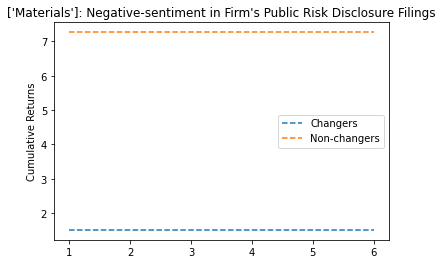

In [24]:
sector_mining_dict =  {'Months':[],'Sector':[],'Investment':[],'Returns':[],'Sharpe':[] }
sector = ['Materials']
sector_review = daily[daily['GICS Sector'].isin(sector)]
# yr_mask = sector_review['Year'] != '2020' #lets remove APD and see if the returns improve
# yr_review = sector_review[yr_mask]

for term in range(30,210,30):
    
    #view portfolio returns by trading days within window per year for the basket
#     daily = yr_review.groupby(['Year','Ticker']).head(term)
    sector_returns = sector_review.groupby(['Year','Ticker']).head(term)
    year  = ['2015','2016','2017','2018','2019','2020']
    tkr_by_year = daily[daily.Year.isin(year)]
    
    df1 = tkr_by_year.loc[(tkr_by_year['Cos_Sim'] < tkr_by_year['Cos_Sim'].quantile(0.20)) &
                (tkr_by_year['Word_chg'] == 1)] #bottom quantile of CSim due to an increase in neg word frequency
    df2 =tkr_by_year.loc[(tkr_by_year['Cos_Sim'] > tkr_by_year['Cos_Sim'].quantile(0.80)) &
                    (tkr_by_year['Word_chg'] == -1)] #top quantile of CSim due to a small change in neg word frequency
      
        
    changers = df1['Return']
    
    change_alpha = get_ret_sharpe(changers, term) #review the dispersion in the sectors at the 60day time window
    change_alpha_ret = round(change_alpha[0],3)
    change_alpha_shp = round(change_alpha[1],3)
    sector_mining_dict['Months'].append(term/30)
    sector_mining_dict['Sector'].append(sector)
    sector_mining_dict['Investment'].append("Changers")
    sector_mining_dict['Returns'].append(change_alpha_ret)
    sector_mining_dict['Sharpe'].append(change_alpha_shp)
    
    non_changers = df2['Return'] #all stocks in dataset, no filter

    nonchange_data = get_ret_sharpe(non_changers, term) #review the dispersion in the sectors at the 60day time window
    nonchange_ret = round(nonchange_data[0],3)
    nonchange_shp = round(nonchange_data[1],3)
    sector_mining_dict['Months'].append(term/30)
    sector_mining_dict['Sector'].append(sector)
    sector_mining_dict['Investment'].append("Non-changers")
    sector_mining_dict['Returns'].append(nonchange_ret)
    sector_mining_dict['Sharpe'].append(nonchange_shp)
    
return_comp_windows = pd.DataFrame(sector_mining_dict)


import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for type in ['Changers','Non-changers']:
    ax.plot(return_comp_windows[return_comp_windows.Investment==type].Months,
            return_comp_windows[return_comp_windows.Investment==type].Returns,
            label=type, linestyle=('--'))

ax.set_title("{}: Negative-sentiment in Firm's Public Risk Disclosure Filings".format(sector))
ax.set_ylabel("Cumulative Returns")
ax.legend(loc='best')

plt.show()

In [25]:
#APD greatly increased its negative word frequency despite that the stock went up 27%??
tkr_review.Filing_Date.unique()
#they generally report in Nov, so that rules out something odd in 2020 filing date, but
#why did it increase so much?

<PeriodArray>
['2020-04-15', '2020-02-26', '2020-02-19', '2020-02-06', '2020-02-24',
 '2020-02-28', '2020-02-14', '2020-03-03', '2020-02-20', '2020-02-21',
 '2020-03-02']
Length: 11, dtype: period[D]